# H264 Video Frame Playback from JSON

This notebook loads H264 video frame data from JSON and plays it back with the original timing to replicate the live streaming experience.

## Process:
1. Load JSON containing frame metadata and base64-encoded H264 data
2. Convert base64 strings to byte arrays (`data_byte_array` field)
3. Decode and display frames one by one with timestamp-based delays

In [42]:
import json
import base64

# Load the frames metadata JSON file
json_file_path = r'2026_02_13\train_21b9a9d7-3719-45eb-9282-9b83f7c443f8_frames_metadata_1770976530756_1770976554363.json'

with open(json_file_path, 'r') as f:
    data = json.load(f)

# Convert base64 data to byte arrays for all frames
print("Converting base64 data to byte arrays...")
for i, frame in enumerate(data['frames']):
    frame['data_byte_array'] = base64.b64decode(frame['data'])

print(f"Conversion complete!\n")

# Display basic information about the loaded data
print(f"Train ID: {data['trainId']}")
print(f"Export Timestamp: {data['exportTimestamp']}")
print(f"Time Range: {data['timeRange']['startTime']} - {data['timeRange']['endTime']}")
print(f"Frame Count: {data['frameCount']}")

Converting base64 data to byte arrays...
Conversion complete!

Train ID: 21b9a9d7-3719-45eb-9282-9b83f7c443f8
Export Timestamp: 1770977332763
Time Range: 1770976530756 - 1770976554363
Frame Count: 303


## Data Structure

After loading, each frame in `data['frames']` contains:
- `frameId`: Original frame number from source (may have gaps)
- `timestamp`: Unix timestamp in milliseconds
- `latency`: Frame latency in milliseconds
- `size`: Frame size in bytes
- `data`: Base64-encoded H264 frame data (original)
- `data_byte_array`: Decoded byte array (added by Cell 2)

The byte arrays are used to create a playable video buffer.

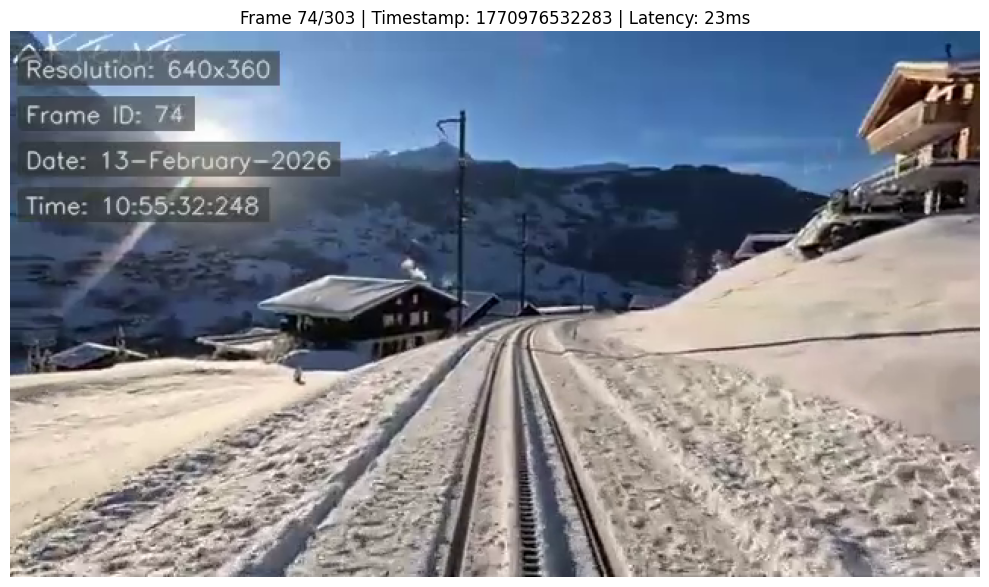

In [ ]:
import av
import numpy as np
import time
from IPython.display import display, clear_output
from matplotlib import pyplot as plt

print(f"Playing {data['frameCount']} frames based on timestamps...")
print("(Playback will display in real-time based on timestamps)\n")

# Create h264 codec for decoding
codec = av.CodecContext.create('h264', 'r')

# Create figure for display
plt.figure(figsize=(10, 7))

prev_timestamp = None
start_time = time.time()

for frame_data in data['frames']:
    av_packet = av.Packet(frame_data['data_byte_array'])
    try:
        frame = codec.decode(av_packet)
        current_timestamp = frame_data['timestamp']
        frame_id = frame_data['frameId']

        # Calculate delay based on timestamp difference
        if prev_timestamp is not None:
            delay_ms = current_timestamp - prev_timestamp
            delay_s = delay_ms / 1000.0
            time.sleep(delay_s)  # Wait to simulate real-time playback

        # Convert frame to numpy array
        frame_rgb = frame[0].to_ndarray(format='rgb24')

        # Display frame
        clear_output(wait=True)
        plt.clf()
        plt.imshow(frame_rgb)
        plt.title(f'Frame {frame_id}/{data["frameCount"]} | Timestamp: {current_timestamp} | Latency: {frame_data["latency"]}ms')
        plt.axis('off')
        plt.tight_layout()
        display(plt.gcf())

        prev_timestamp = current_timestamp
    except Exception as e:
        print(f"Error decoding frame {frame_data['frameId']}: {e}")

plt.close()

elapsed = time.time() - start_time
print(f"\nPlayback complete!")
